# Train a SNN obeying Dale's Law on the SHD dataset

In this notebook, we demonstrate the training of a 1-hidden-layer SNN obeying Dale's law on the [SHD dataset](https://zenkelab.org/resources/spiking-heidelberg-datasets-shd/).

We will introduce the `DalianLayer` class from the `layer` module, and use the `FluctuationDrivenExponentialInitializer` class from the `initializer` module to initialize the Dalian network in the flucutation-driven regime.

In [46]:
import os
import sys

sys.path.append("../../stork-1/")

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm

# change the default color cycle
np.random.seed(20250129)
plt.rcParams["axes.prop_cycle"] = plt.cycler(
    color=np.random.permutation(cm.batlow(np.linspace(0, 1, 10)))
)

import stork
from stork.activations import CustomSpike
from stork.datasets import HDF5Dataset, DatasetView
from stork.models import RecurrentSpikingModel
from stork.nodes import InputGroup, ReadoutGroup, ExcInhLIFGroup
from stork.connections import Connection
from stork.generators import StandardGenerator
from stork.initializers import FluctuationDrivenExponentialInitializer, DistInitializer
from stork.layers import DalianLayer
from stork.plotting_new import plot_training

## Load Dataset

***To locally run this notebook on your system, download the SHD dataset from: [https://zenkelab.org/datasets/](https://zenkelab.org/datasets/).***
*We need 'shd_train.h5' and 'shd_test.h5'. Move the downloaded files into a folder `datasets/hdspikes` in this repo, or change the `datadir` variable below. 

In [28]:
datadir = "/tachyon/groups/gzenke/datasets/hdspikes"

#### Specifying dataset parameters

In [29]:
nb_inputs = 700
duration = 0.7
time_step = dt = 2e-3
nb_time_steps = int(duration / time_step)
time_scale = 1
unit_scale = 1
validation_split = 0.9

gen_kwargs = dict(
    nb_steps=nb_time_steps,
    time_scale=time_scale / time_step,
    unit_scale=unit_scale,
    nb_units=nb_inputs,
    preload=True,
    precompute_dense=False,
    unit_permutation=None,
)

#### Load and split dataset into train / validation / test

In [30]:
train_dataset = HDF5Dataset(os.path.join(datadir, "shd_train.h5"), **gen_kwargs)

# Split into train and validation set
mother_dataset = train_dataset
elements = np.arange(len(mother_dataset))
np.random.shuffle(elements)
split = int(validation_split * len(mother_dataset))
valid_dataset = DatasetView(mother_dataset, elements[split:])
train_dataset = DatasetView(mother_dataset, elements[:split])

test_dataset = HDF5Dataset(os.path.join(datadir, "shd_test.h5"), **gen_kwargs)

## Set up the model

In [31]:
# Model Parameters
# # # # # # # # # # #

beta = 20
nb_hidden_layers = 1
nb_classes = 20
nb_exc_neurons = 128  # Number of excitatory neurons in the hidden layer
ei_ratio = 4  # Number of inhibitory neurons = nb_exc_neurons / ei_ratio

# Neuron Parameters
# # # # # # # # # # #
neuron_group = ExcInhLIFGroup

exc_neuron_kwargs = {"tau_mem": 20e-3, "tau_exc": 10e-3, "tau_inh": 20e-3}
inh_neuron_kwargs = {"tau_mem": 20e-3, "tau_exc": 10e-3, "tau_inh": 20e-3}
tau_readout = duration

# Training parameters
# # # # # # # # # # #

batch_size = 400
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float
lr = 5e-3
nb_epochs = 200

#### SuperSpike and loss function setup

In [32]:
act_fn = CustomSpike
act_fn.escape_noise_type = "sigmoid"
act_fn.escape_noise_params = {"beta": beta}

act_fn.surrogate_type = "SuperSpike"
act_fn.surrogate_params = {"beta": beta}

loss_stack = stork.loss_stacks.SumOfSoftmaxCrossEntropy()

#### Optimizer setup

In [33]:
opt = stork.optimizers.SMORMS3
generator = StandardGenerator(nb_workers=4)

In [34]:
# Define regularizer parameters (set regularizer strenght to 0 if you don't want to use them)
upperBoundL2Strength = 0.1
upperBoundL2Threshold = (
    7  # Regularizes spikecount: 7 spikes ~ 10 Hz in 700ms simulation time
)

# Define regularizer list
regs = []

regUB = stork.regularizers.UpperBoundL2(
    upperBoundL2Strength, threshold=upperBoundL2Threshold, dims=-1
)
regs.append(regUB)

#### Initializer setup
We initialize in the fluctuation-driven regime with a target membrane potential standard deviation $\sigma_U=1.0$. Additionally, we set the proportion of membrane potential fluctuations driven by feed-forward inputs to $\alpha=0.9$.

In [35]:
sigma_u = 1.0
nu = 15.8

initializer = FluctuationDrivenExponentialInitializer(
    sigma_u=sigma_u, nu=nu, timestep=dt, alpha=0.9
)

readout_initializer = DistInitializer(
    dist=torch.distributions.Normal(0, 1), scaling="1/sqrt(k)"
)

#### Assemble the model

In [36]:
model = RecurrentSpikingModel(batch_size, nb_time_steps, nb_inputs, device, dtype)
# INPUT LAYER
# # # # # # # # # # # # # # #
input_group = model.add_group(InputGroup(nb_inputs))

# Set input group as upstream of first hidden layer
upstream_group = input_group

# HIDDEN LAYER
# # # # # # # # # # # # # # #

layer = DalianLayer(
    name="Hid. 1",
    model=model,
    size=nb_exc_neurons,
    ei_ratio=ei_ratio,
    input_group=upstream_group,
    recurrent=True,
    neuron_class=neuron_group,
    exc_neuron_kwargs=exc_neuron_kwargs,
    inh_neuron_kwargs=inh_neuron_kwargs,
    regs=regs,
)

# Initialize Parameters
initializer.initialize(layer)

# Set output as input to next layer
upstream_group = layer.output_group

# READOUT LAYER
# # # # # # # # # # # # # # #
readout_group = model.add_group(
    ReadoutGroup(nb_classes, tau_mem=tau_readout, tau_syn=10e-3, initial_state=-1e-3)
)

readout_connection = model.add_connection(
    Connection(upstream_group, readout_group, flatten_input=True)
)

# Initialize readout connection
readout_initializer.initialize(readout_connection)

#### Configure model for training

In [37]:
model.configure(
    input=input_group,
    output=readout_group,
    loss_stack=loss_stack,
    generator=generator,
    optimizer=opt,
    optimizer_kwargs=dict(lr=lr),
    time_step=dt,
)

## Monitoring activity before training

In [38]:
# Monitors spike counts before training
results = {}

res = model.monitor(test_dataset)
for k, v in res.items():
    results["Pre test " + k] = v.cpu().numpy()
    print(k, v.shape)

res = model.monitor(train_dataset)
for k, v in res.items():
    results["Pre train " + k] = v.cpu().numpy()
    print(k, v.shape)
# print(results)

plotting


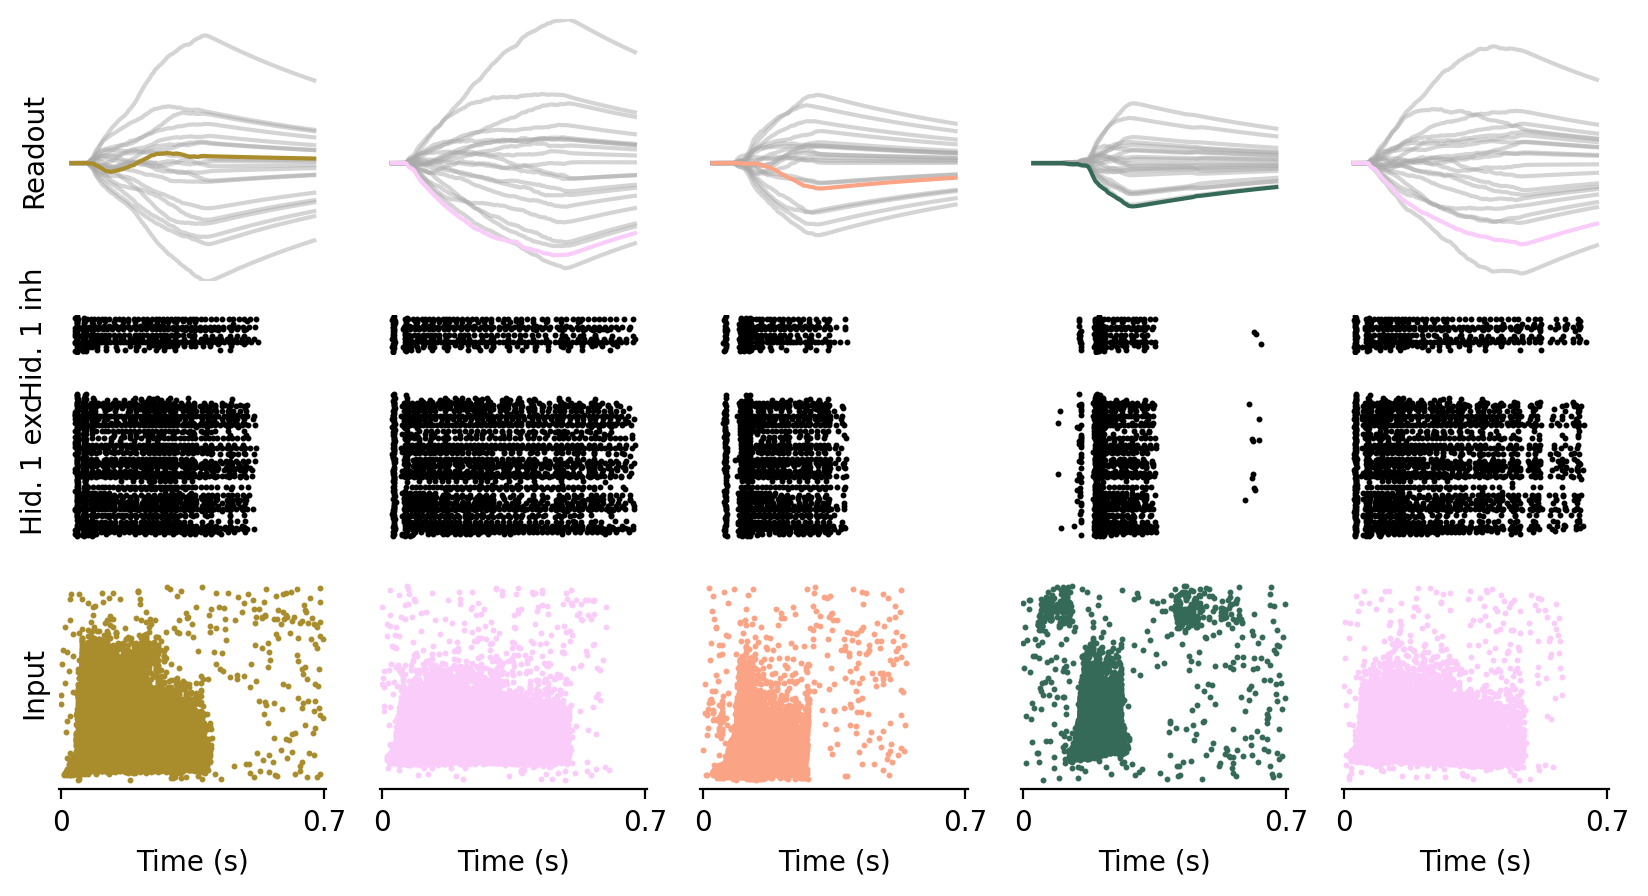

In [39]:
# create nice classification color palette for plotting
colors = cm.batlow(np.linspace(0, 1, nb_classes))

pl = stork.plotting_new.ActivityPlotter(
    model=model,
    data=test_dataset,
    nb_samples=5,
    figsize=(10, 5),
    dpi=200,
    plot_label=True,
    label_color="navy",
    batch_size=batch_size,
    pal=colors,
    scale_input=0.25
)
fig = pl.plot_activity()

## Training

takes around 50 Minutes on a GPU

In [40]:
history = model.fit_validate(train_dataset, valid_dataset, nb_epochs=nb_epochs, verbose=True)

for k, v in history.items():
    if k in results:
        results[k] = np.concatenate([results[k], v], axis=0)
    else:
        results[k] = np.array(v)

scores = model.evaluate(test_dataset).tolist()
print("Scores", scores)
test_dict = model.get_metrics_dict(scores, prefix="test_")

for k, v in test_dict.items():
    if k in results:
        results[k] = np.concatenate([results[k], [v]], axis=0)
    else:
        results[k] = np.array([v])

00  loss = 3.122e+00, reg_loss = 9.280e-01, acc = 9.7% -- val_loss = 2.740e+00, val_reg_loss = 6.164e-02, val_acc = 25.8% t_iter=19.29
01  loss = 2.466e+00, reg_loss = 5.200e-02, acc = 21.1% -- val_loss = 2.559e+00, val_reg_loss = 4.249e-02, val_acc = 20.9% t_iter=19.81
02  loss = 2.003e+00, reg_loss = 2.818e-02, acc = 36.0% -- val_loss = 1.980e+00, val_reg_loss = 1.839e-02, val_acc = 35.1% t_iter=18.58
03  loss = 1.677e+00, reg_loss = 2.731e-02, acc = 46.6% -- val_loss = 1.541e+00, val_reg_loss = 4.055e-02, val_acc = 46.0% t_iter=19.27
04  loss = 1.357e+00, reg_loss = 3.125e-02, acc = 56.2% -- val_loss = 1.341e+00, val_reg_loss = 2.332e-02, val_acc = 59.1% t_iter=19.46
05  loss = 1.143e+00, reg_loss = 2.974e-02, acc = 63.0% -- val_loss = 1.316e+00, val_reg_loss = 2.525e-02, val_acc = 57.2% t_iter=19.16
06  loss = 9.455e-01, reg_loss = 3.067e-02, acc = 69.6% -- val_loss = 8.721e-01, val_reg_loss = 3.419e-02, val_acc = 77.4% t_iter=19.29
07  loss = 7.891e-01, reg_loss = 3.079e-02, acc =

plotting


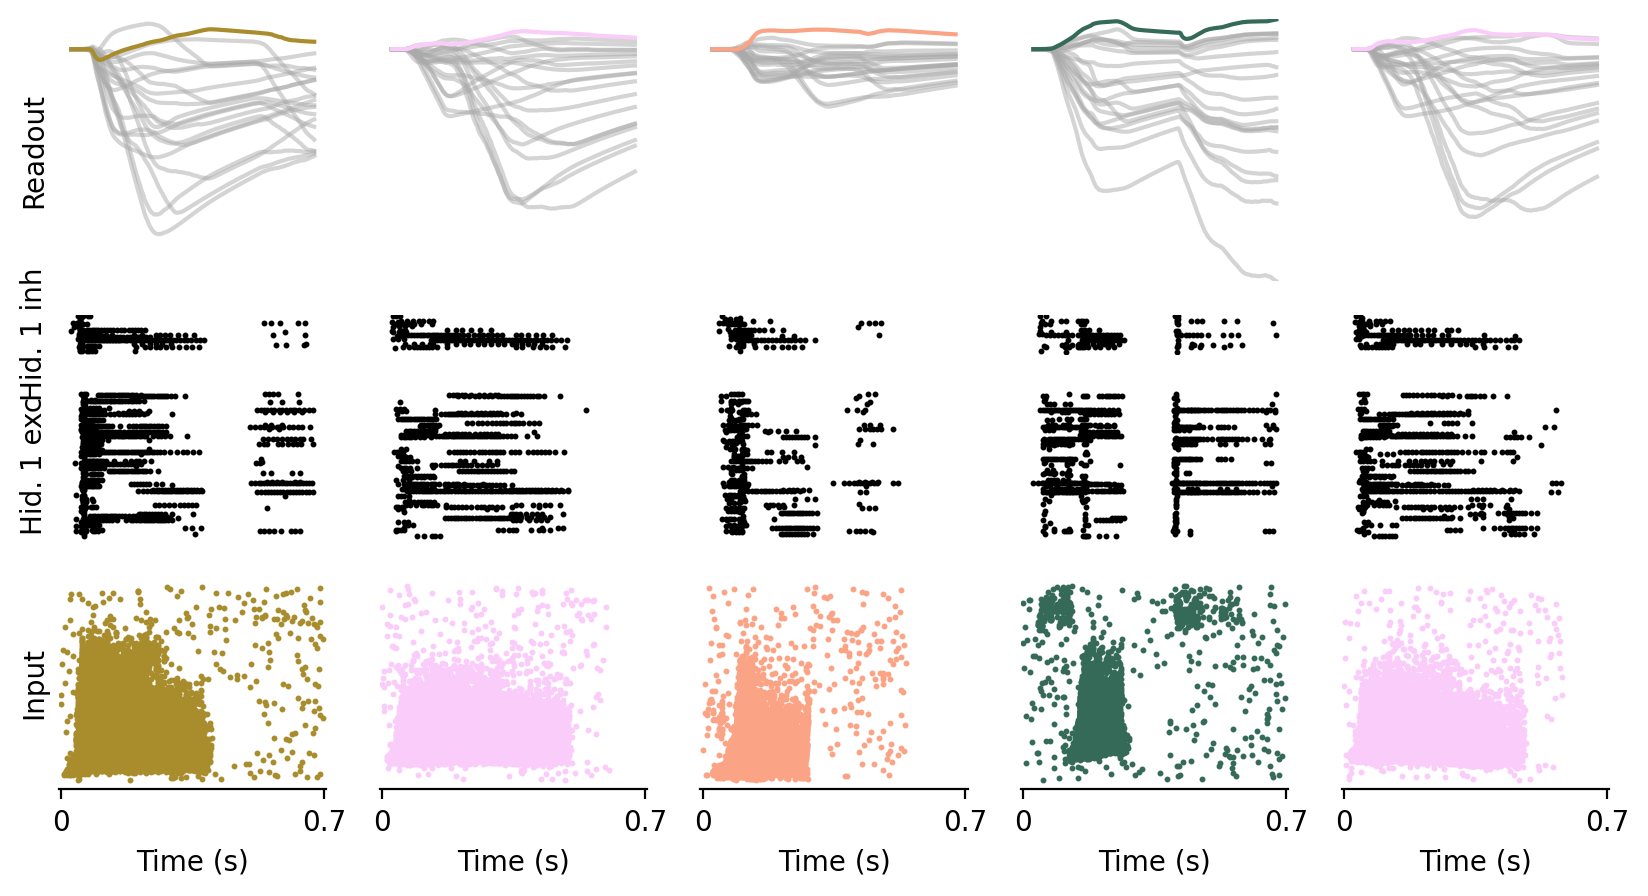

In [41]:
fig = pl.plot_activity()


In [42]:
res = model.monitor(test_dataset)
for k, v in res.items():
    results["Post test " + k] = v.cpu().numpy()
    print(k, v.shape)

res = model.monitor(train_dataset)
for k, v in res.items():
    results["Post train " + k] = v.cpu().numpy()
    print(k, v.shape)
# print(results)

## Test

In [43]:
scores = model.evaluate(test_dataset).tolist()

print("Test acc:", np.round(results["test_acc"][-1]*100, 2), "%")

Test acc: 85.77 %


#### Visualize performance

dict_keys(['loss', 'reg_loss', 'acc', 'val_loss', 'val_reg_loss', 'val_acc', 'test_loss', 'test_reg_loss', 'test_acc'])
['loss', 'reg_loss', 'acc']


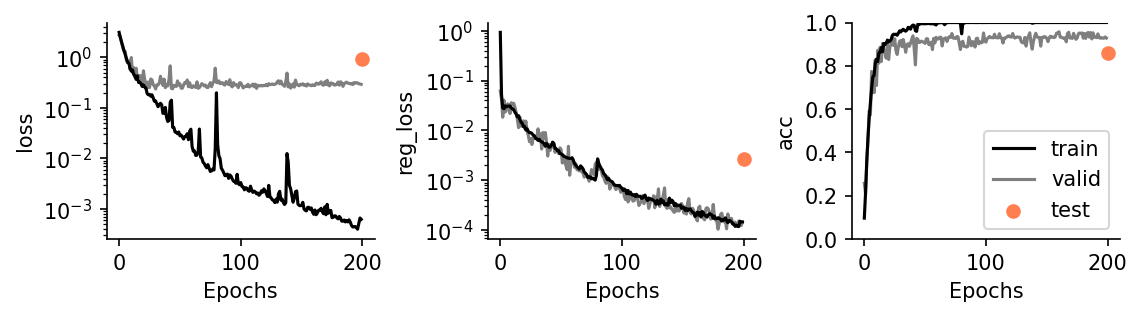

In [47]:
print(results.keys())
names = [k for k in results.keys() if not ("val" in k or "test" in k or "Monitor" in k)]
print(names)

fig = plot_training(
    results,
    nb_epochs=nb_epochs,
    epoch_chunks=1,  # cfg.training.epoch_chunks,
    names=names,
)

#### Snapshot after training